In [10]:
#@title Klik tombol play di bawah untuk memulai! {display-mode: "form"}
!pip install mediapipe > /dev/null

import random
from IPython.display import display, HTML
from google.colab import drive
from google.colab import auth
from googleapiclient.discovery import build
from IPython.display import clear_output
import IPython

# Create a Google Drive API client
!git clone -q https://github.com/aryawidjaja/tracerstudyitb.git
alphabets = [chr(i) for i in range(ord('A'), ord('Z')+1)]
random_alphabet = random.choice(alphabets)
#@title Klik tombol berikut untuk mengacak huruf selanjutnya! {display-mode: "form"}
import ipywidgets as widgets
import random

# Create a button widget
button = widgets.Button(description='Acak huruf')

# Define a function to handle button click event
def on_button_clicked(button):
    global random_alphabet  # Access the global variable
    alphabets = ['A', 'B', 'C', 'Y', 'O']  # Replace with your list of alphabets
    random_alphabet = random.choice(alphabets)
    return random_alphabet


fatal: destination path 'tracerstudyitb' already exists and is not an empty directory.


<IPython.core.display.Javascript object>

1/1 [==============================] - 2s 2s/step


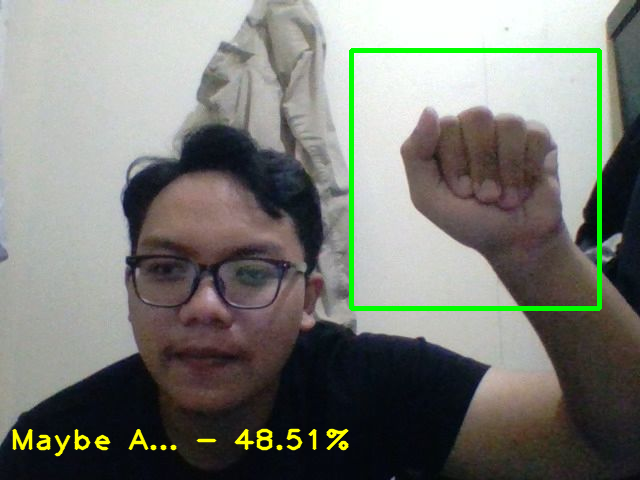

Button(description='Acak huruf', style=ButtonStyle())

In [17]:
#@title Ayo praktik membentuk huruf bahasa isyarat bersama siBi! {display-mode: "form"}

#alphabets = [chr(i) for i in range(ord('A'), ord('Z')+1)]
#random_alphabet = random.choice(alphabets)

# Define the text and font size
text = f"Bentuklah huruf {random_alphabet} dengan tanganmu di depan kamera!"
font_size = "26px"

def html_text_gen(text, font_size):
  html = f'<span style="font-size: {font_size};">{text}</span>'
  return html

# Display the HTML
instr = html_text_gen(text, font_size)
display(HTML(instr))

import cv2
import numpy as np
from IPython.display import display, Image, Javascript
from base64 import b64decode
from google.colab.output import eval_js
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import mediapipe as mp
from google.cloud import storage
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from flask import Flask, request, jsonify

def accessDriveModel(file_name, service_account_file):
    from google.oauth2 import service_account
    import googleapiclient.discovery
    from googleapiclient.http import MediaIoBaseDownload
    import io
    import os

    # Load the service account credentials
    credentials = service_account.Credentials.from_service_account_file(service_account_file)

    # Create a Google Drive API client
    drive_service = googleapiclient.discovery.build('drive', 'v3', credentials=credentials)

    # Specify the file name
    file_name = file_name

    # Search for the file by name
    query = "name = '{}'".format(file_name)
    response = drive_service.files().list(q=query).execute()

    # Check if the file exists
    if 'files' not in response or len(response['files']) == 0:
        raise FileNotFoundError("File not found in Google Drive")

    # Extract the file ID from the response
    file_id = response['files'][0]['id']

    # Download the file
    request = drive_service.files().get_media(fileId=file_id)
    file_stream = io.BytesIO()
    downloader = MediaIoBaseDownload(file_stream, request)
    done = False
    while not done:
        status, done = downloader.next_chunk()

    # Save the file locally
    local_file_path = "/content/" + file_name
    with open(local_file_path, 'wb') as f:
        f.write(file_stream.getvalue())

    # Return the local file path
    return local_file_path


# Create a client to interact with Google Cloud Storage
client = storage.Client()

# Prepare data generator for standardizing frames before sending them into the model.
data_generator = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)

# Loading the model
file_name = "SIBI_model.h5"
service_account_file = "/content/tracerstudyitb/service_account.json"  # Update with the actual path

model_path = accessDriveModel(file_name, service_account_file)

# Now you can load the model using the local file path
model = load_model(model_path)

# Setting up the input image size and frame crop size.
IMAGE_SIZE = 200
CROP_SIZE = 400

# Creating list of available classes stored in classes.txt.
classes = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','del','nothing','space']
classes.sort()  # The predict function sends out output in sorted order.

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      // Flip the image horizontally.
      const ctx = canvas.getContext('2d');
      ctx.translate(canvas.width, 0);
      ctx.scale(-1, 1);
      ctx.drawImage(video, 0, 0, canvas.width, canvas.height);

      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

def aslpredict():
  # Capture frame-by-frame.
  filename = 'photo.jpg'
  take_photo(filename)
  cap = cv2.VideoCapture(filename)
  ret, frame = cap.read()
  image = cv2.imread("photo.jpg")
  frame_height, frame_width, _ = image.shape

  # Hand tracking using Mediapipe
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  results = hands.process(image_rgb)
  hand_landmarks = results.multi_hand_landmarks

  if hand_landmarks:
    for hand_landmark in hand_landmarks:
      x_min = int(min(hand_landmark.landmark, key=lambda p: p.x).x * frame_width)
      y_min = int(min(hand_landmark.landmark, key=lambda p: p.y).y * frame_height)
      x_max = int(max(hand_landmark.landmark, key=lambda p: p.x).x * frame_width)
      y_max = int(max(hand_landmark.landmark, key=lambda p: p.y).y * frame_height)

  # Enlarge the bounding rectangle
  scale_factor = 2
  center_x = (x_min + x_max) // 2
  center_y = (y_min + y_max) // 2
  new_width = int((x_max - x_min) * scale_factor)
  new_height = int((y_max - y_min) * scale_factor)
  x = max(0, center_x - new_width // 2)
  y = max(0, center_y - new_height // 2)
  w = min(frame_width - x, new_width)
  h = min(frame_height - y, new_height)

  # Draw the enlarged bounding rectangle
  cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 3)

  # Preprocessing the frame before input to the model.
  cropped_image = image[y:y + h, x:x + w]
  resized_frame = cv2.resize(cropped_image, (IMAGE_SIZE, IMAGE_SIZE))
  reshaped_frame = (np.array(resized_frame)).reshape((1, IMAGE_SIZE, IMAGE_SIZE, 3))
  frame_for_model = data_generator.standardize(np.float64(reshaped_frame))

  # Predicting the frame.
  prediction = np.array(model.predict(frame_for_model))
  predicted_class = classes[prediction.argmax()]

  return prediction, predicted_class, image, cap


# Create a hand tracking module instance
hands = mp.solutions.hands.Hands(
    max_num_hands=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
)

# Preparing cv2 for webcam feed
#filename = 'photo.jpg'
#take_photo(filename)
#cap = cv2.VideoCapture(filename)

prediction_displayed = False  # Flag variable to track if prediction has been shown
loop = True
while loop:
    prediction, predicted_class, image, cap = aslpredict()
    # Preparing output based on the model's confidence.
    prediction_probability = prediction[0, prediction.argmax()]
    if prediction_probability > 0.5:
        # High confidence.
        cv2.putText(image, '{} - {:.2f}%'.format(predicted_class, prediction_probability * 100),
                    (10, 450), 1, 2, (255, 255, 0), 2, cv2.LINE_AA)
        prediction_displayed = True  # Set the flag to True
    elif 0.2 < prediction_probability <= 0.5:
        # Low confidence.
        cv2.putText(image, 'Maybe {}... - {:.2f}%'.format(predicted_class, prediction_probability * 100),
                    (10, 450), 1, 2, (0, 255, 255), 2, cv2.LINE_AA)
        prediction_displayed = True  # Set the flag to True
    else:
        # No confidence.
        cv2.putText(image, classes[-2], (10, 450), 1, 2, (255, 255, 0), 2, cv2.LINE_AA)
        prediction_displayed = True  # Set the flag to True

    # Display the image with prediction and bounding rectangle
    cv2_imshow(image)

    # If prediction displayed, break the loop.
    if prediction_displayed:
        if predicted_class == random_alphabet:
            instr = html_text_gen("Wow hebat, kamu benar!", "22px")
            display(HTML(instr))
            instr = html_text_gen("Ayo bermain lagi dengan menekan tombol \u25B6 di kiri atas yaa \U0001F60A, tapi sebelumnya acak dulu hurufnya yuk!", "22px")
            display(HTML(instr))
            loop = False
        else:
            #print("Ups, kamu belum benar. Coba lagi!")
            instr = html_text_gen("Yah belum benar \U0001F614 Coba lagi yuk! Klik lagi tombol \u25B6 di kiri atas yaa \U0001F60A", "22px")
            display(HTML(instr))
            loop = False
    # Attach the button click event handler
    button.on_click(on_button_clicked)
    #instr = html_text_gen("Klik tombol berikut untuk mengacak huruf selanjutnya! \U0001F60A", "20px")
    #display(HTML(instr))
    # Display the button
    display(button)